<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/Timeseries/time_series_lstm_electricity_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'electric-power-consumption-data-set:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F122%2F260%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T014723Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D64443141516cfecae776beb6bd26a1a43e159b2b66002408720991644b781a01b35d765e26e5372f59c59427a88cba8b86d2282b11f4661d29ea78d28852d714dacee877bfea3371d737922261e2191bb2344578c5557d0499aa3760a269036a544a4ccbdd2be5c35a2356c32770b2a58ee719a29fad452d840b282a3f3c25c9286490cd241a13a0115901e44c7a7e0c1ac46cc3a72ddbb831316b24e2ba8604f8179b2c9b7dc9e98559777473d4cd7f3cf186df6e3c55a7c8269a55a34e2a36bdce745b043ac17d5bcb7fcffa550ffe8948371c6bfa67d082bf6ef271950eced246f98f324cfc50ed401bdb4b4e4ff958297c696e990ee7cff41e5ccc0cf2ba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20357475 bytes downloaded
Downloaded and uncompressed: electric-power-consumption-data-set
Data source import complete.


# **Multi-Step LSTM Time-Series Forecasting Models for Power Usage**

# 1. About the Data

**Data Source**

[Household Electric Power Consumption from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)


**Data Background**

* The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption (with a one-minute sampling rate) for a single household over four years

* The data contains 2,075,259 observations and 8 features (including timestamp) collected from a house in France between December 2006 and November 2010


**Data Dictionary**

|Variable|Definition|
|:---|:---|
|Datetime|yyyy-mm-dd hh:mm:ss
|Global_active_power|The total active power in kilowatts (kW) consumed by the household
|Global_reactive_power|The total reactive power in kilowatts (kW) consumed by the household
|Voltage|Average voltage (V)
|Global_intensity|Average current intensity (A)
|Sub_metering_1|Active energy for kitchen in watt-hours (Wh)
|Sub_metering_2|Active energy for laundry in watt-hours (Wh)
|Sub_metering_3|Active energy for climate control systems in watt-hours (Wh)
|Sub_metering_4$^{1}$|Active energy in watt-hours (Wh)

$^{1}$Newly created feature using the following calculation: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)

---

# 2. Business question

* What is the expected household power usage for each day over the next seven days?

---

# 3. Documentation summary and data insights

Exploratory data analysis, insights drawn from it and time-series modelling can be summarized as follows:

|||
|:---|:---|
|**Initial data exploration:**|* The data set contains 8 features (including time) and 2,075,259 observations
||* Column names were cleaned (strings to lower case)
||* '?' were replaced with missing values ('NaN')
||* Object datatypes were converted to float, all datatypes ended up being float
||* Missing values (25,979 per feature) were imputed with a value at the same time one day ago
||* A new feature 'sub_metering_4' was created, because the total energy consumption was larger than the sum of the three sub meters combined. The new feature was calculated as follows: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)
||* Dataset spans 1441 days (2006-12-16 to 2010-11-26)
||
|**Data visualization:**|* 'voltage' is a constant and can therefore be dropped for subsequent analysis
||**Histograms:**
||* 'global_active_power' (power consumption) data was converted from per-minute sampling (2,075,259 observations) into total daily consumption (1442 observations)
||* Target variable 'global_active_power' (total daily power consumption) is almost normally distributed with a slight positive skew
||**Time series:**
||* Target variable 'global_active_power' (total daily power consumption): time-series is stationary and shows seasonality. However, variance shows some variability. Exclude the first 5 months for modelling?
||**Correlation heatmap:**
||* 'global_intensity' is highly correlated with other features and should therefore be dropped before modelling
||
|**Test for stationarity:**|* Augmented Dicky-Fuller test concluded that the time series is stationary
||
|**Modelling:**|* A total of 4 multi-step LSTM prediction models were used, two based on univariate and two based on multivariate analysis
||* For each analysis, two main types of LSTM models for multi-step forecasting were employed: Vector Output Model (Stacked LSTM) and Encoder-Decoder Model
||* Data was split into 75% train (1082 observations) and 25% test (360 observations)
||* The data was scaled using mean and standard deviation of the train set
||* A sliding window approach was used to create multiple input/output samples (X, y) from the time-series sequence
||* 14 days of past observations (input X) were used to forecast a 7-day period (output y), i.e. 1062 train and 340 test samples were created with 14 timesteps for X and 7 timesteps for y each
||* Models were optimized using a loss function and learning curves were plotted showing training and validation loss
||* Model prediction was performed on elements of the test set and plotted against actual data
||* Evaluation metric RMSE was used to compare model performance
||* Under the current conditions employed (i.e., number of input/output steps, model definitions, etc.), univariate models performed slightly better than multivariate models. However, it must be noted that the **models had not been tuned**, only the number of nodes were adjusted to reduce over-fitting
||

---

# 4. Loading Python libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.ticker import StrMethodFormatter
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
# Check library version
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)

Numpy:  1.25.2
Pandas:  2.0.3
Seaborn:  0.13.1


---

# 5. Exploratory data analysis

## 5.1. Loading data

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [6]:
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', header=0, low_memory=False,
                 infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=0)

<ipython-input-6-cc910416aff3>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', header=0, low_memory=False,
<ipython-input-6-cc910416aff3>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', header=0, low_memory=False,


## 5.2. Exploring and cleaning data

In [7]:
# Check data dimension
df.shape

(2075259, 7)

In [8]:
# Preview data
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
 df.tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0
2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


In [10]:
# Clean column names
df.columns = df.columns.str.lower()

In [11]:
# Summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    object 
 1   global_reactive_power  object 
 2   voltage                object 
 3   global_intensity       object 
 4   sub_metering_1         object 
 5   sub_metering_2         object 
 6   sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [12]:
# Generate descriptive statistics
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
global_active_power,2075259,4187,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_reactive_power,2075259,533,0.000,481561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voltage,2075259,2838,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_intensity,2075259,222,1.000,172785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_1,2075259,89,0.000,1880175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_2,2075259,82,0.000,1436830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_3,2049280.0,NaN,NaN,NaN,6.458447,8.437154,0.0,0.0,1.0,17.0,31.0


In [13]:
# Replace '?' with missing value ('NaN') and check
df.replace('?', 'NaN', inplace=True)
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
global_active_power,2075259,4187,NaN,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_reactive_power,2075259,533,0.000,481561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voltage,2075259,2838,NaN,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
global_intensity,2075259,222,1.000,172785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_1,2075259,89,0.000,1880175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_2,2075259,82,0.000,1436830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_metering_3,2049280.0,NaN,NaN,NaN,6.458447,8.437154,0.0,0.0,1.0,17.0,31.0


In [14]:
# Convert all dtypes to float and check
df = df.astype('float')
df.dtypes

global_active_power      float64
global_reactive_power    float64
voltage                  float64
global_intensity         float64
sub_metering_1           float64
sub_metering_2           float64
sub_metering_3           float64
dtype: object

In [15]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


In [16]:
# Check for missing values
df.isna().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

In [17]:
# # Function to fill missing values with a value at the same time one day ago
# def fill_missing(values):
#   one_day = 60 * 24
#   for row in range(values.shape[0]):
#     for col in range(values.shape[1]):
#       if np.isnan(values[row, col]):
#         # print("Copying ",values[row - one_day, col]," in location", row, col)
#         values[row, col] = values[row - one_day, col]\

In [18]:
#commenting above fill_missing function since it is not working as expected.
df.ffill(inplace=True)

In [19]:
# Check for missing values; it should be 0 now if above function works properly
df.isna().sum().sum()

0

In [20]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2075259.0,1.086168,1.053172,0.076,0.308,0.598,1.524,11.122
global_reactive_power,2075259.0,0.123328,0.112514,0.000,0.048,0.100,0.194,1.390
voltage,2075259.0,240.841608,3.235574,223.200,239.000,241.020,242.870,254.150
global_intensity,2075259.0,4.604226,4.426775,0.200,1.400,2.600,6.400,48.400
sub_metering_1,2075259.0,1.110995,6.115908,0.000,0.000,0.000,0.000,88.000
sub_metering_2,2075259.0,1.287958,5.786865,0.000,0.000,0.000,1.000,80.000
sub_metering_3,2075259.0,6.416570,8.419505,0.000,0.000,1.000,17.000,31.000


Note! Note! Note! Note! Note!

The total energy consumption was larger than the sum of the three sub meters combined. Therefore, add a new feature 'sub_metering_4' will be added according to the following calculation: global_active_power * 1000/60 - (sub_metering_1 + sub_metering_2 + sub_metering_3)

In [21]:
# Add column for remaining sub metering
df['sub_metering_4'] = (df.iloc[:, 0] * 1000 / 60) - (df.iloc[:, 4] + df.iloc[:, 5] + df.iloc[:, 6])
df.head(3)

# Alternatively,
# values = df.values
# df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667


In [22]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2075259.0,1.086168,1.053172,0.076,0.308,0.598,1.524,11.122000
global_reactive_power,2075259.0,0.123328,0.112514,0.000,0.048,0.100,0.194,1.390000
voltage,2075259.0,240.841608,3.235574,223.200,239.000,241.020,242.870,254.150000
global_intensity,2075259.0,4.604226,4.426775,0.200,1.400,2.600,6.400,48.400000
sub_metering_1,2075259.0,1.110995,6.115908,0.000,0.000,0.000,0.000,88.000000
sub_metering_2,2075259.0,1.287958,5.786865,0.000,0.000,0.000,1.000,80.000000
sub_metering_3,2075259.0,6.416570,8.419505,0.000,0.000,1.000,17.000,31.000000
sub_metering_4,2075259.0,9.287283,9.545391,-2.400,3.800,5.500,10.400,124.833333


In [23]:
# Check index
df.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='datetime', length=2075259, freq=None)

In [24]:
# Dataset timeframe
print('Dataset start', df.index.min())
print('Dataset end', df.index.max())
print('Dataset spans', df.index.max() - df.index.min())

Dataset start 2006-12-16 17:24:00
Dataset end 2010-11-26 21:02:00
Dataset spans 1441 days 03:38:00


---

## 5.3. Visualizing data

### 5.3.1. Plotting data based on one-minute sampling rate

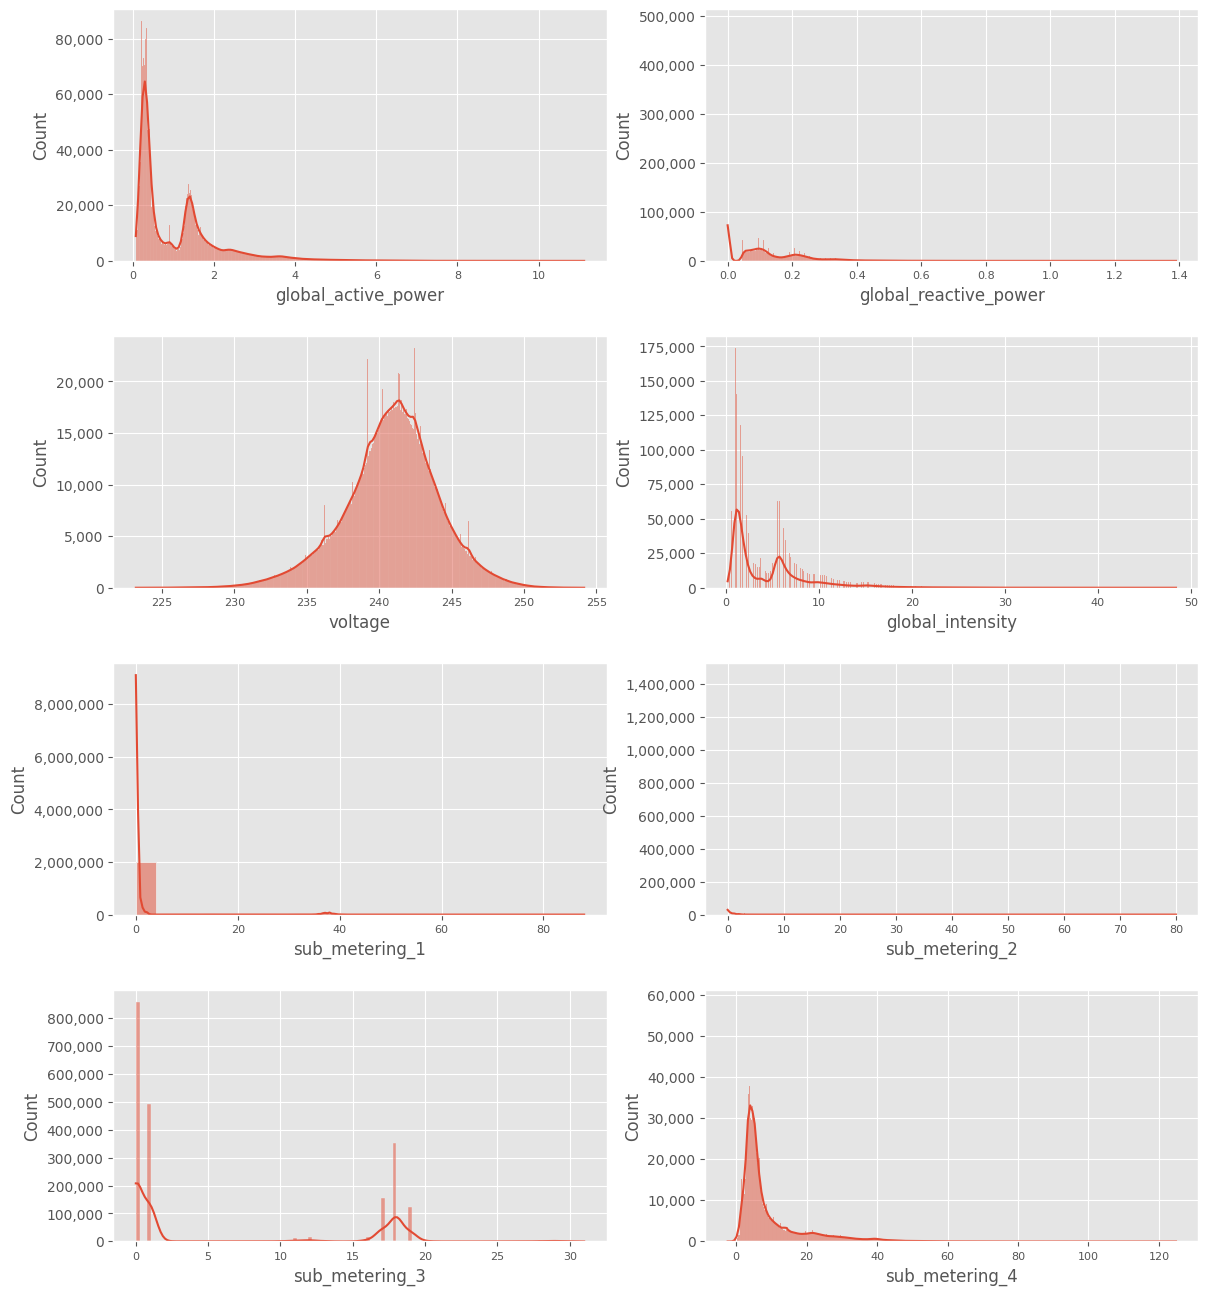

In [25]:
## Histograms: Plotting feature distributions

# Features to plot
columns = df.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=df, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

**Documentation**
* Voltage is a constant and will therefore be dropped for subsequent analysis

### 5.3.2. Plotting data based on hourly-sampling rate

Convert power consumption data from per-minute sampling into total hourly consumption and drop voltage

In [26]:
# Convert (or resample) time series minutes data (here into total per hour data)
hdf = df.drop(['voltage'], axis=1).resample('H').sum()

# Summarize resampled df
print(hdf.shape)
hdf.head(3)

(34589, 7)


,global_active_power,global_reactive_power,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,651.6,0.0,19.0,607.0,1907.733333
2006-12-16 18:00:00,217.932,4.802,936.0,0.0,403.0,1012.0,2217.200000
2006-12-16 19:00:00,204.014,5.114,870.2,0.0,86.0,1001.0,2313.233333


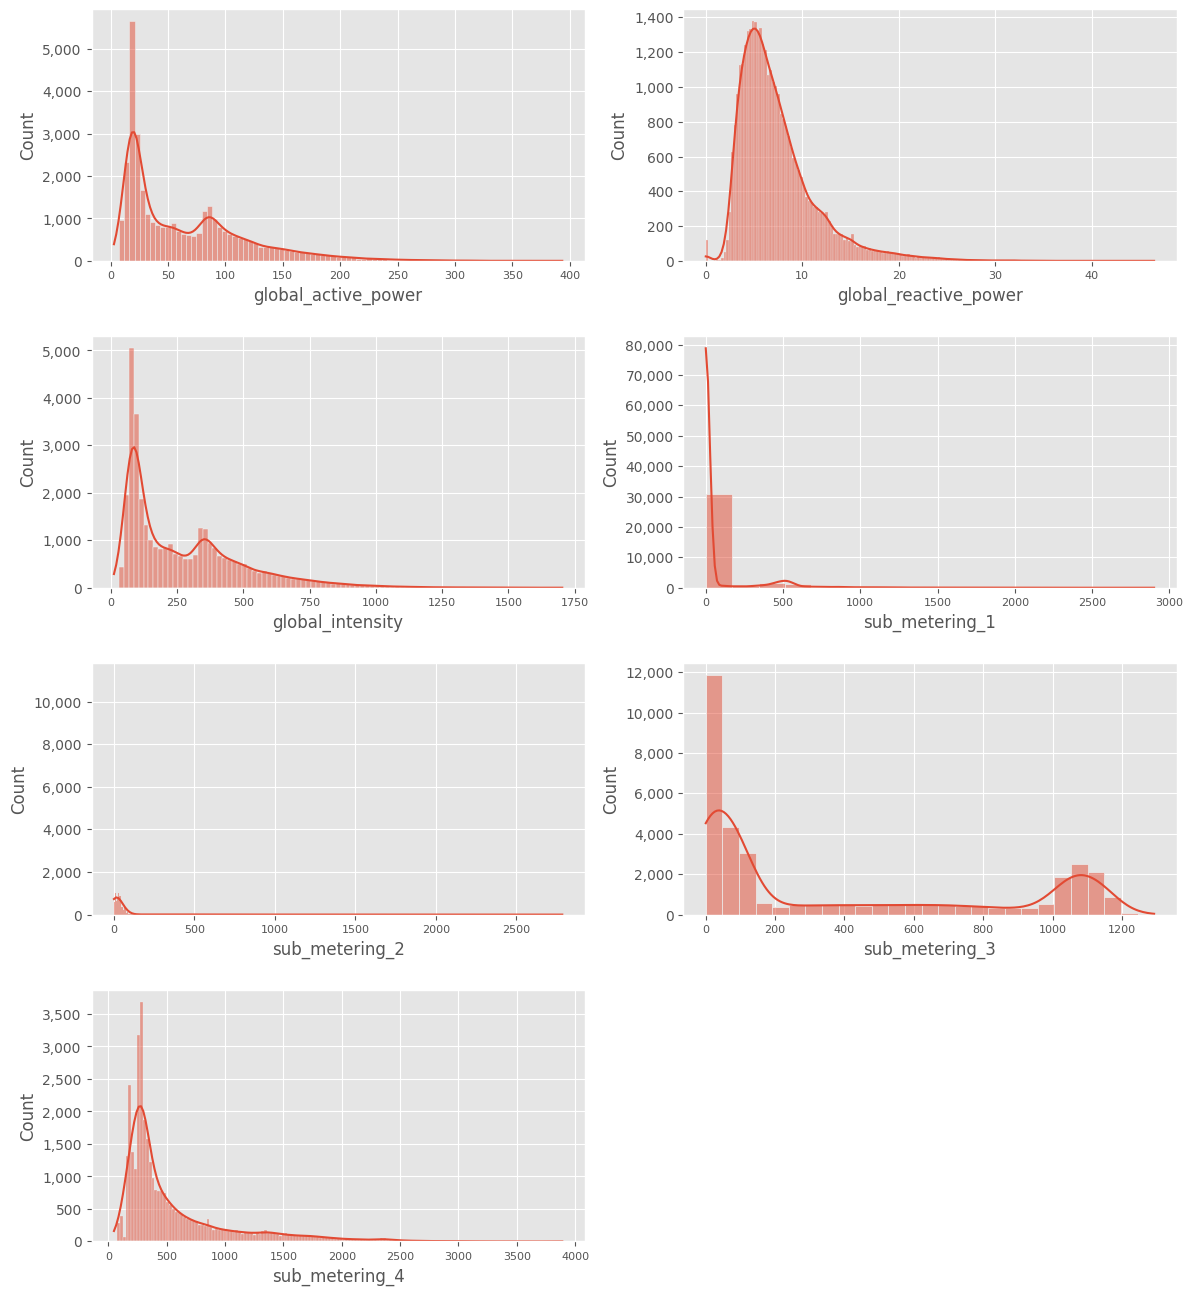

In [27]:
## Histograms: Plotting feature distributions

# Features to plot
columns = hdf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=hdf, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

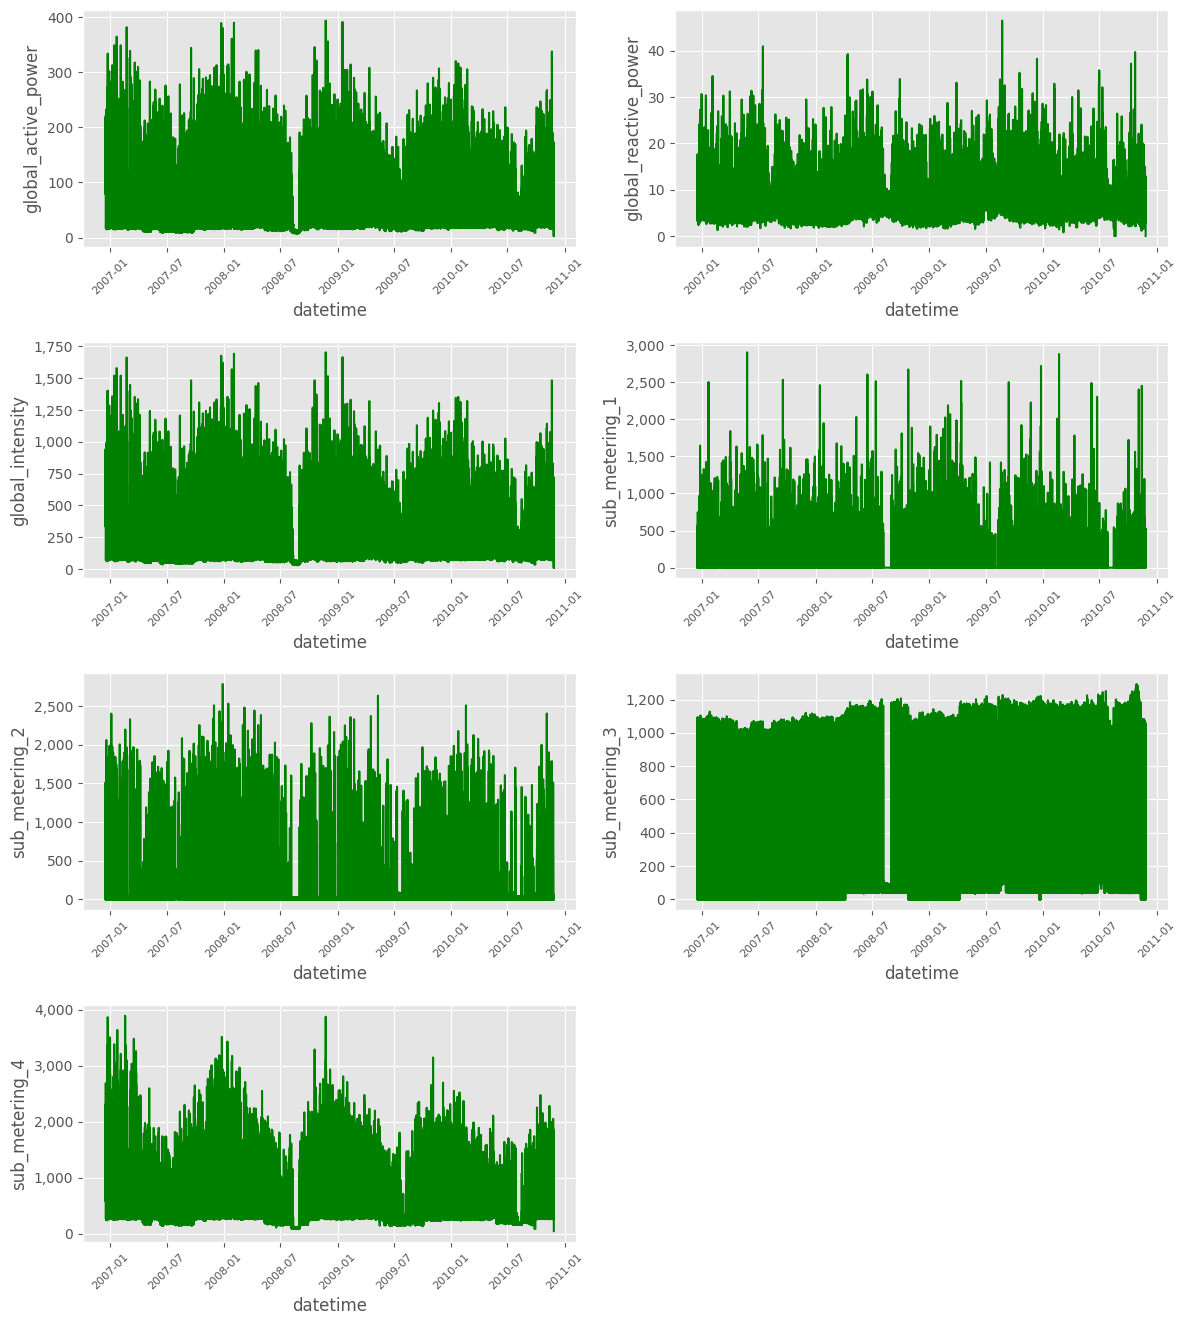

In [28]:
## Plotting features over time

# Features to plot
columns = hdf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=hdf, x=hdf.index, y=col, ax=ax, color='green')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

### 5.3.3. Plotting data based on daily-sampling rate

Convert power consumption data from per-minute sampling into total daily consumption and drop voltage

In [29]:
# Convert (or resample) time series minutes data (here into total per day data)
ddf = df.drop(['voltage'], axis=1).resample('D').sum()

# Summarize resampled df
print(ddf.shape)
ddf.head(3)

(1442, 7)


,global_active_power,global_reactive_power,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,
2006-12-16,1209.176,34.922,5180.8,0.0,546.0,4926.0,14680.933333
2006-12-17,3390.460,226.006,14398.6,2033.0,4187.0,13341.0,36946.666667
2006-12-18,2203.826,161.792,9247.2,1063.0,2621.0,14018.0,19028.433333


In [ ]:
# Save dataset
# ddf.to_csv('household_power_consumption_days.csv')

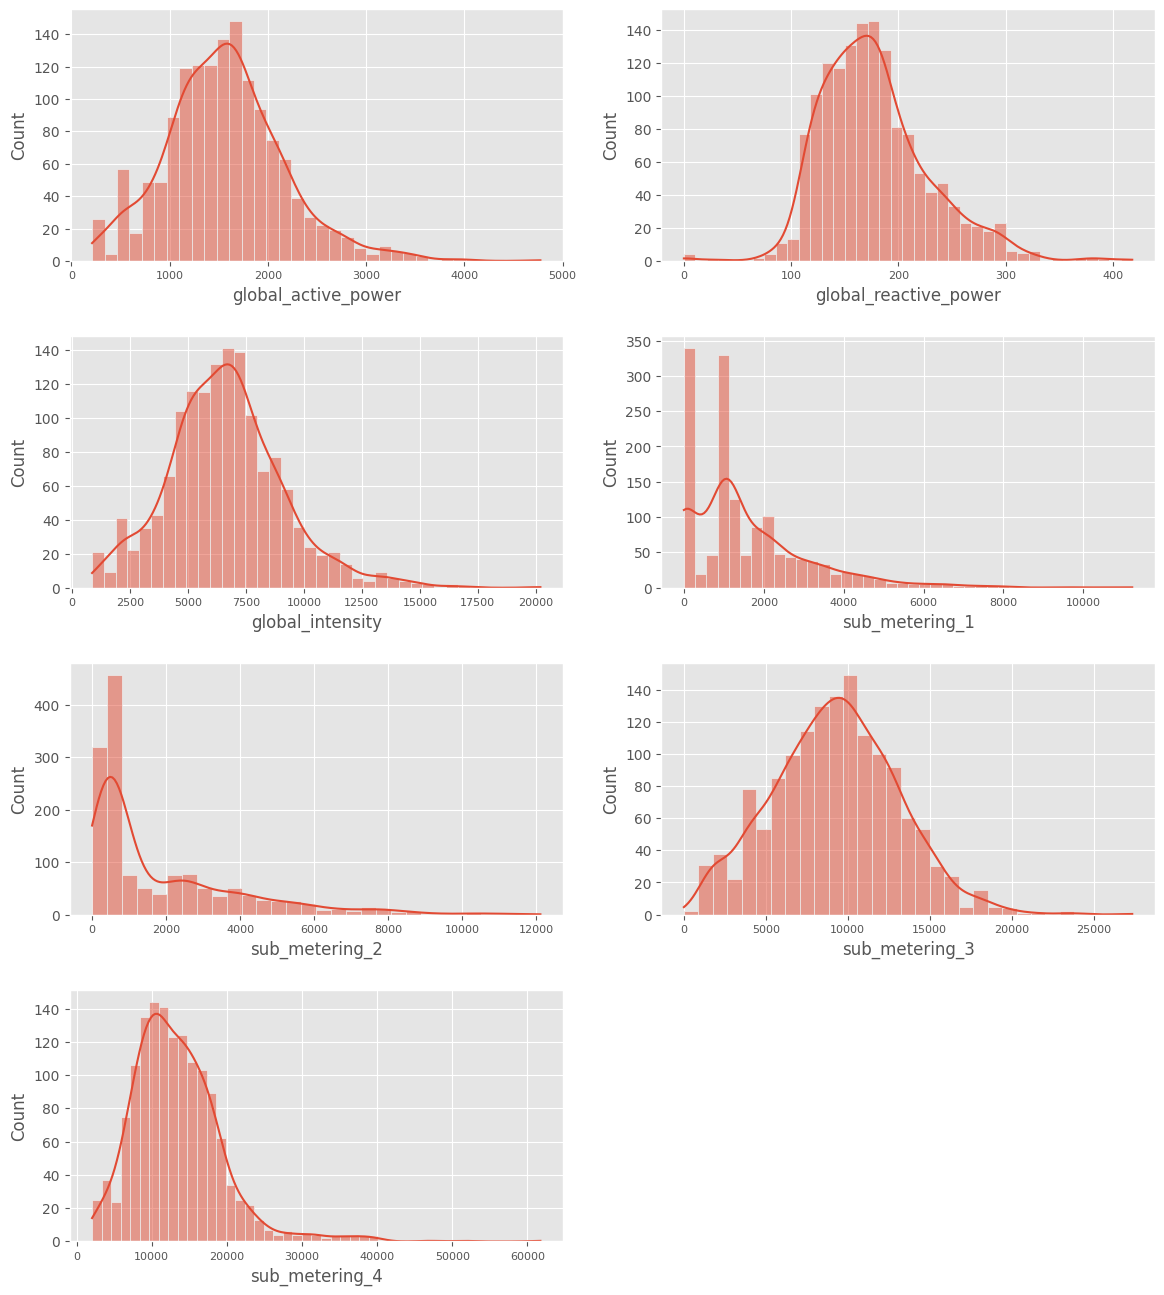

In [30]:
## Histograms: Plotting feature distributions

# Features to plot
columns = ddf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=ddf, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

**Documentation**
* Target variable 'global_active_power' (total daily power consumption) is almost normally distributed with a slight skew to the right

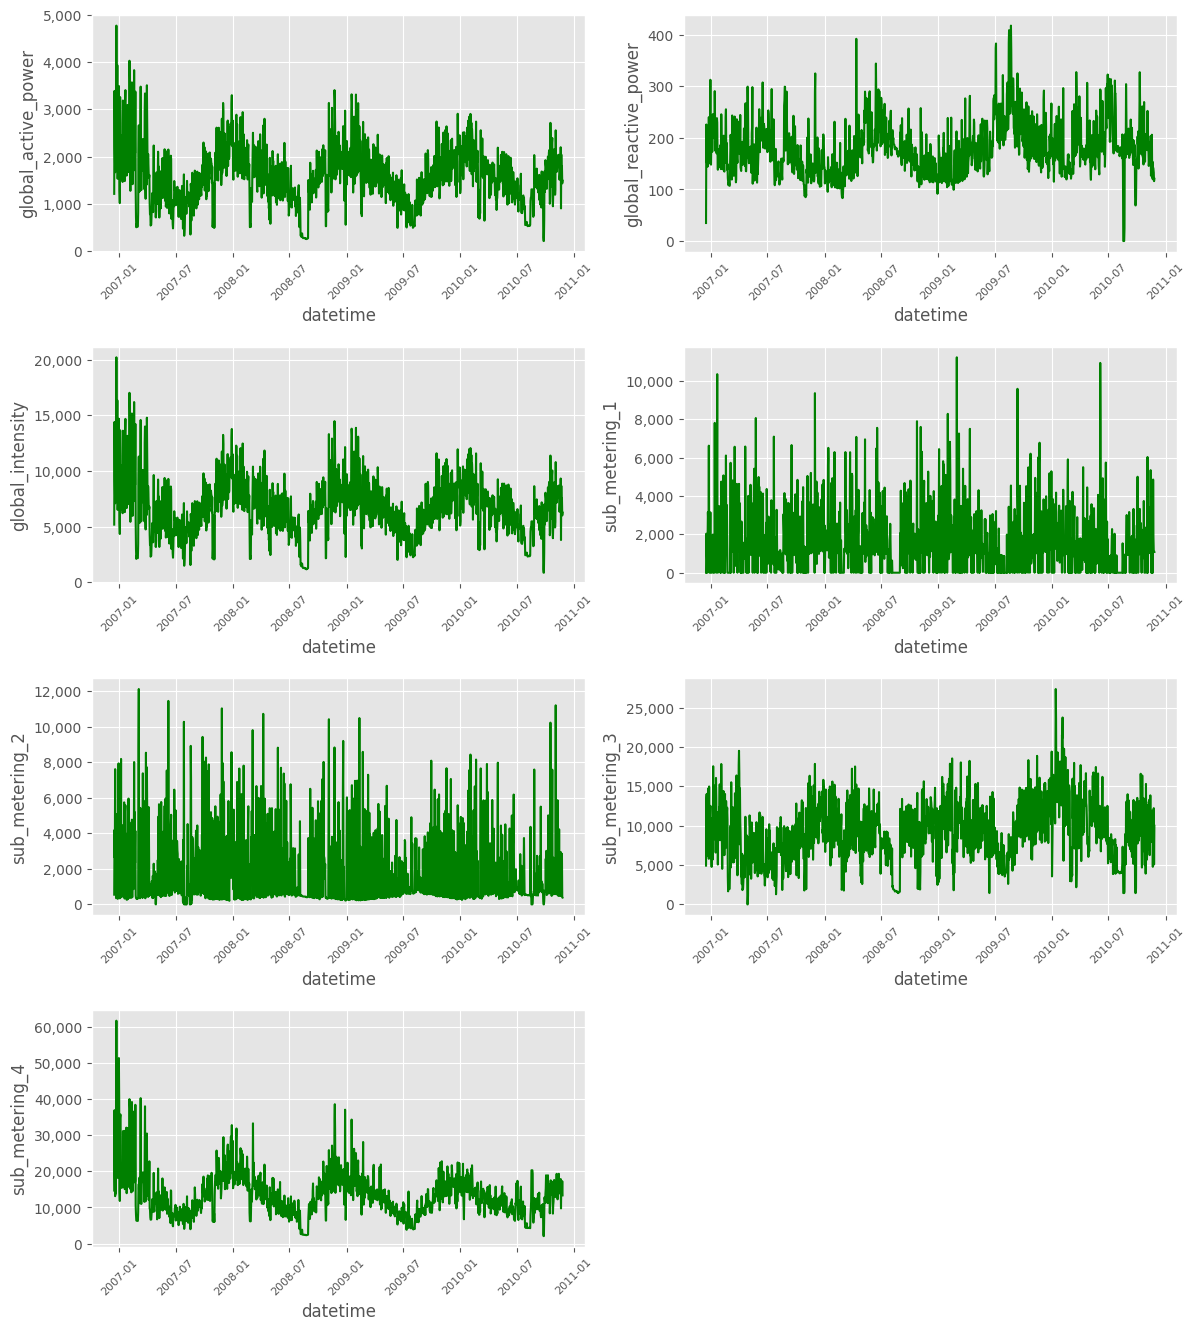

In [31]:
## Plotting features over time

# Features to plot
columns = ddf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=ddf, x=ddf.index, y=col, ax=ax, color='green')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

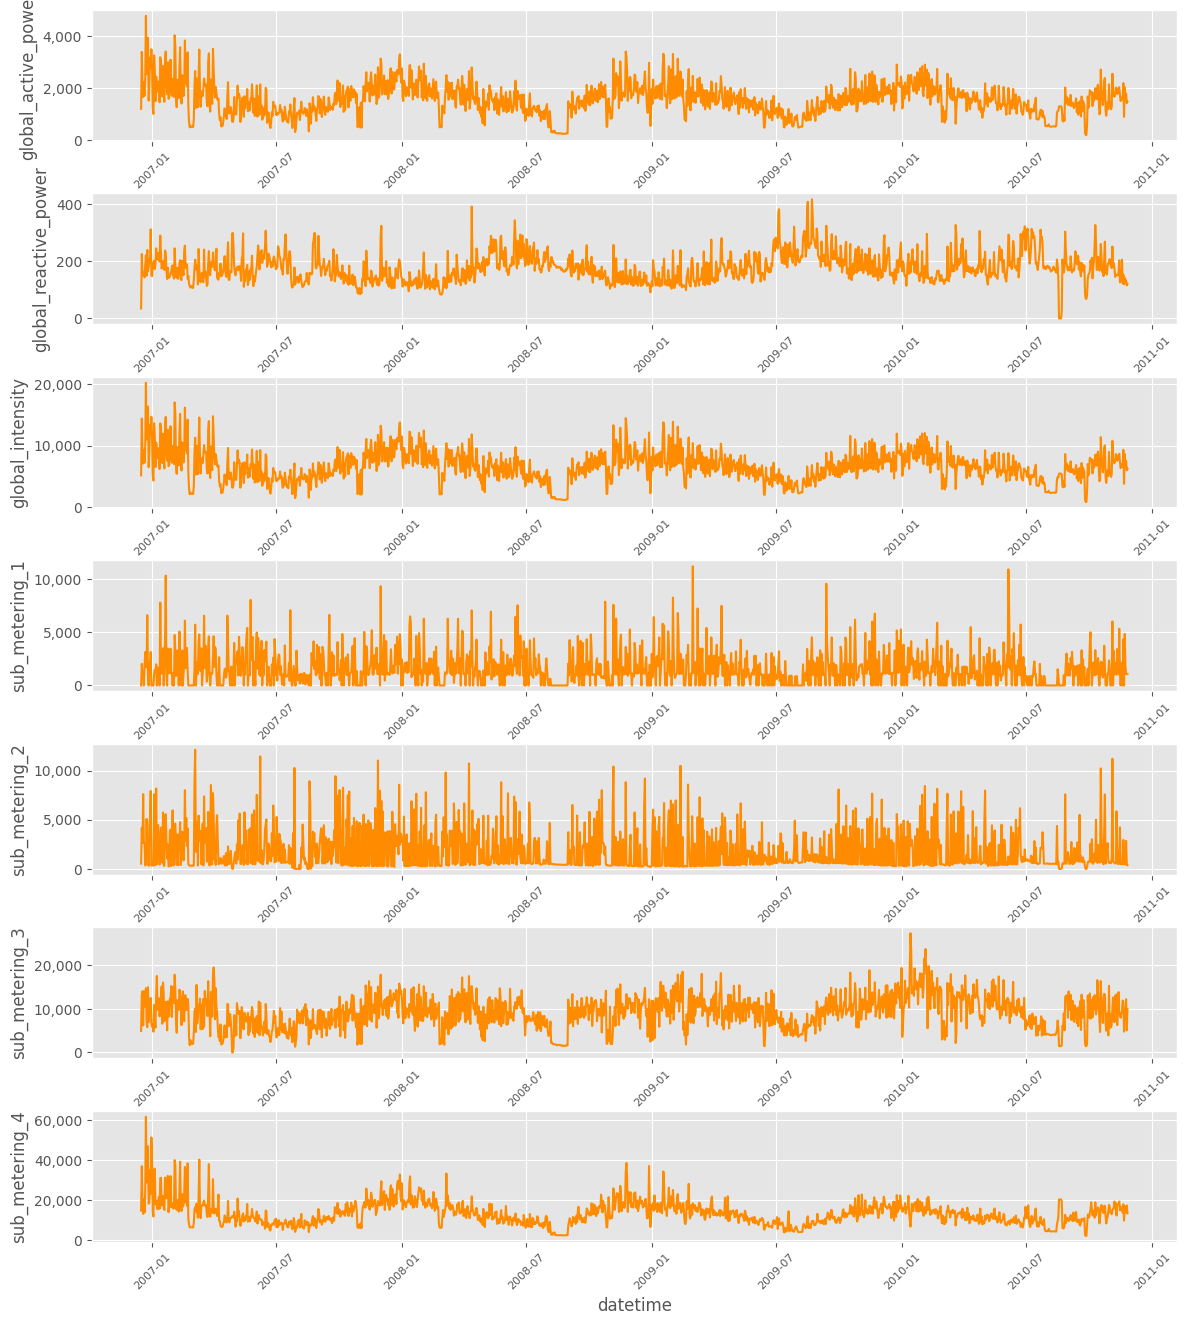

In [32]:
## Plotting features over time (with a different aspect ratio)

# Features to plot
columns = ddf.columns

# Creating subplot axes
fig, axes = plt.subplots(7, 1, figsize=(14,16), sharey=False)

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=ddf, x=ddf.index, y=col, ax=ax, color='darkorange')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

**Documentation**
* Target variable 'global_active_power' (total daily power consumption): time-series is stationary and shows seasonality. However, variance shows some variability. Exclude the first couple of months for modelling?

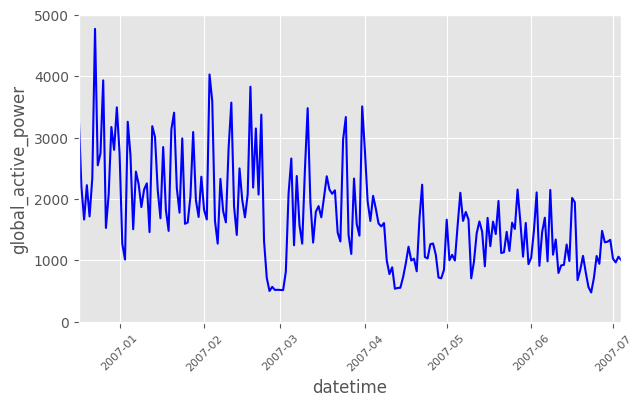

In [33]:
## Plot global_active_power for the first 8 months to check when variance decreased

plt.figure(figsize=(7,4))
sns.lineplot(data=ddf, x=ddf.index, y='global_active_power', color='blue')
plt.tick_params(axis='x', labelrotation=45, labelsize=8)

# Zoom in
plt.xlim([ddf.index[1], ddf.index[200]]);

**Documentation**
* Exclude the first 5 months for modelling?

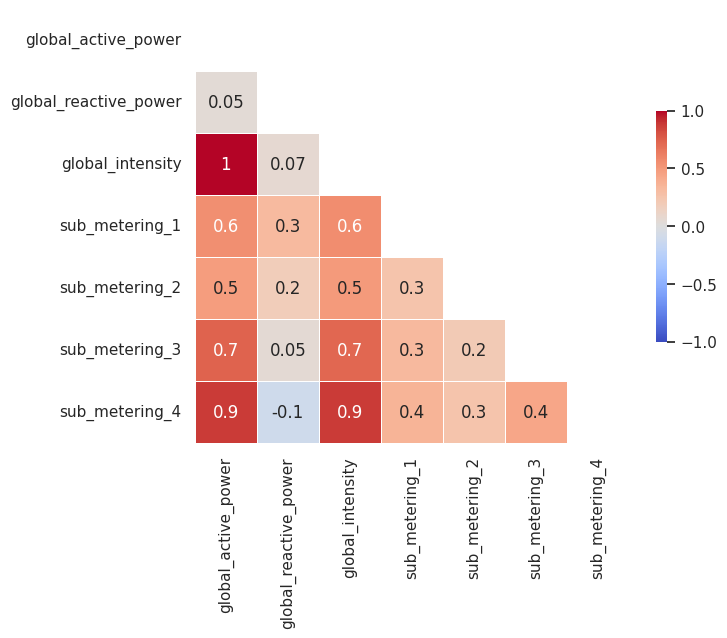

In [34]:
## Correlation heatmap
sns.set_theme(style="white")
plt.subplots(figsize=(7,6))

# Generate mask for upper triangle
mask = np.zeros_like(ddf.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(ddf.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

**Documentation**
* 'global_intensity' is highly correlated with other features and should therefore be dropped before modelling

#### 5.3.3.1. Stationarity: Augmented Dicky-Fuller test

A statistical test to identify whether a time series is non-stationary is the augmented Dicky-Fuller test.

**Null hypothesis H$_{0}$: Time series is not stationary due to trend.**

In [35]:
results = adfuller(ddf['global_active_power']) #results object is a tuple

# Print Dicky-Fuller test results
print(f'Dicky-Fuller test results:{results}\n') #0th element: test statistic, 1st element: pval

# Print test statistic
print(f'test statistic:{results[0]}\n')

# Print p-value
print(f'p-value:{np.round(results[1], 3)}\n')

# Print critical values
print(f'critical values:{results[4]}\n')

# Significance statement
alpha = 0.05

if results[1] < alpha:
    print(f'\033[1mp-value < {alpha}: We reject the null hypothesis\nConclusion: Time series is stationary\033[0m')
else:
    print(f'\033[1mp-value > {alpha}: We accept the null hypothesis\nConclusion: Time series is not stationary due to trend\033[0m')

Dicky-Fuller test results:(-3.7600523102137915, 0.0033435208887408084, 22, 1419, {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}, 21032.920170453523)

test statistic:-3.7600523102137915

p-value:0.003

critical values:{'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}

p-value < 0.05: We reject the null hypothesis
Conclusion: Time series is stationary


### 5.3.4. Plotting data based on monthly-sampling rate

Convert power consumption data from per-minute sampling into total monthly consumption and drop voltage

In [36]:
# Convert (or resample) time series minutes data (here into total per month data)
mdf = df.drop(['voltage'], axis=1).resample('M').sum()

# Summarize resampled df
print(mdf.shape)
mdf.head(3)

(48, 7)


,global_active_power,global_reactive_power,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,sub_metering_4
datetime,,,,,,,
2006-12-31,41826.206,2890.264,176649.2,27536.0,48750.0,162987.0,457830.433333
2007-01-31,69017.230,5922.962,292264.0,56433.0,79274.0,329611.0,684969.166667
2007-02-28,56494.978,4581.728,238489.2,47584.0,64604.0,270308.0,559086.966667


In [37]:
plt.style.use('ggplot')

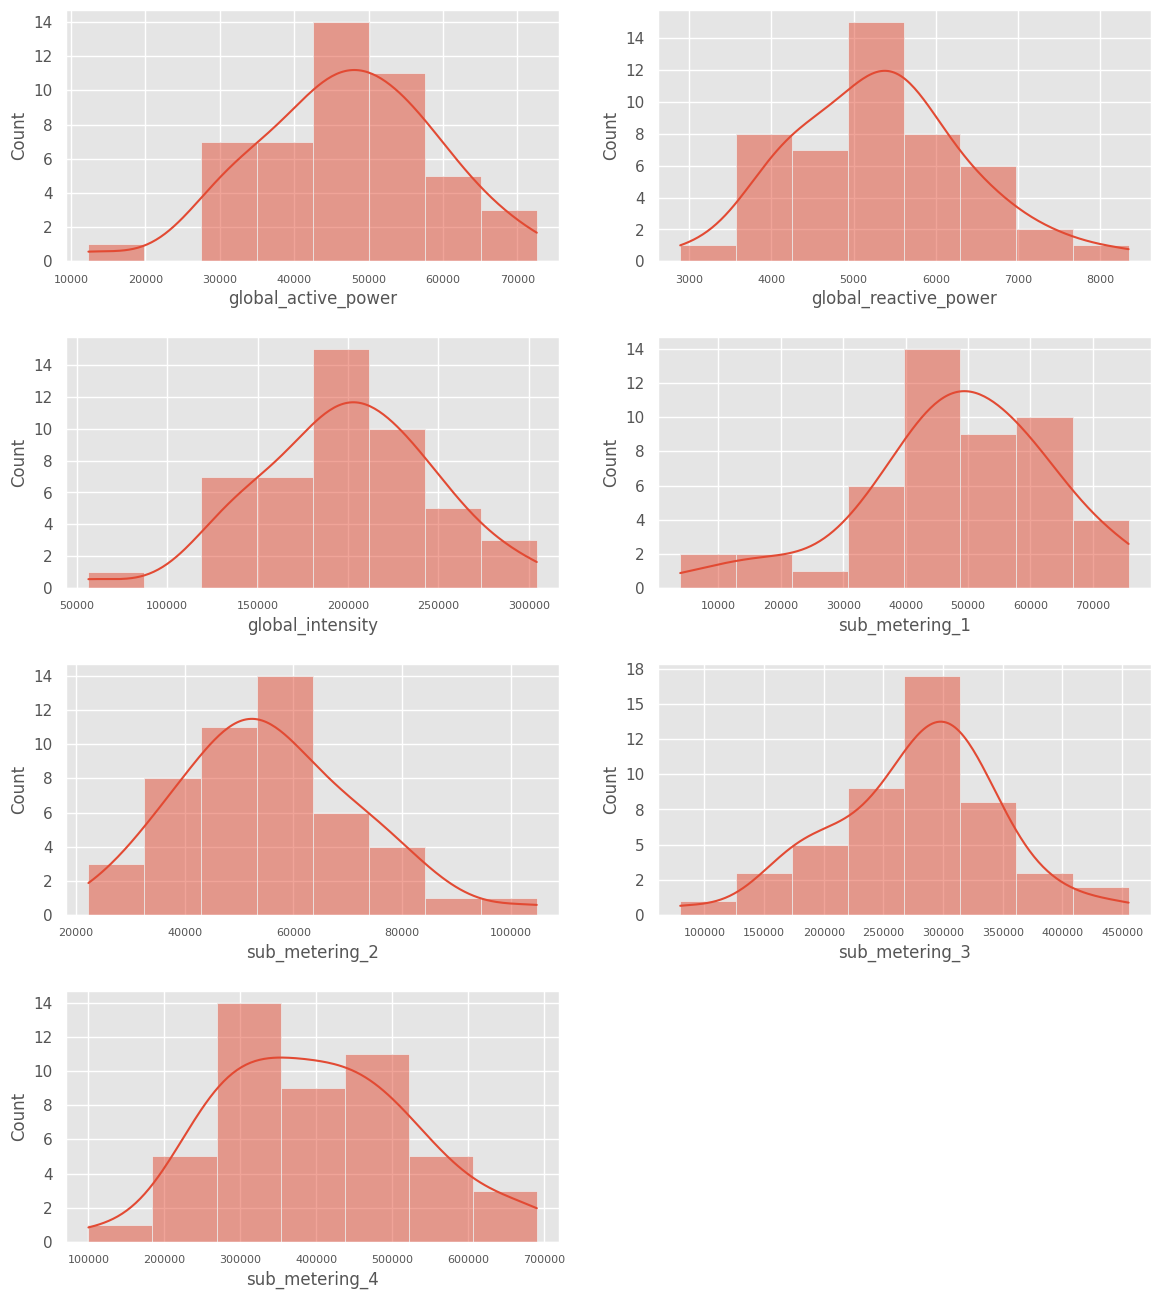

In [38]:
## Histograms: Plotting feature distributions

# Features to plot
columns = mdf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.histplot(x=col, kde=True, data=mdf, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.3);

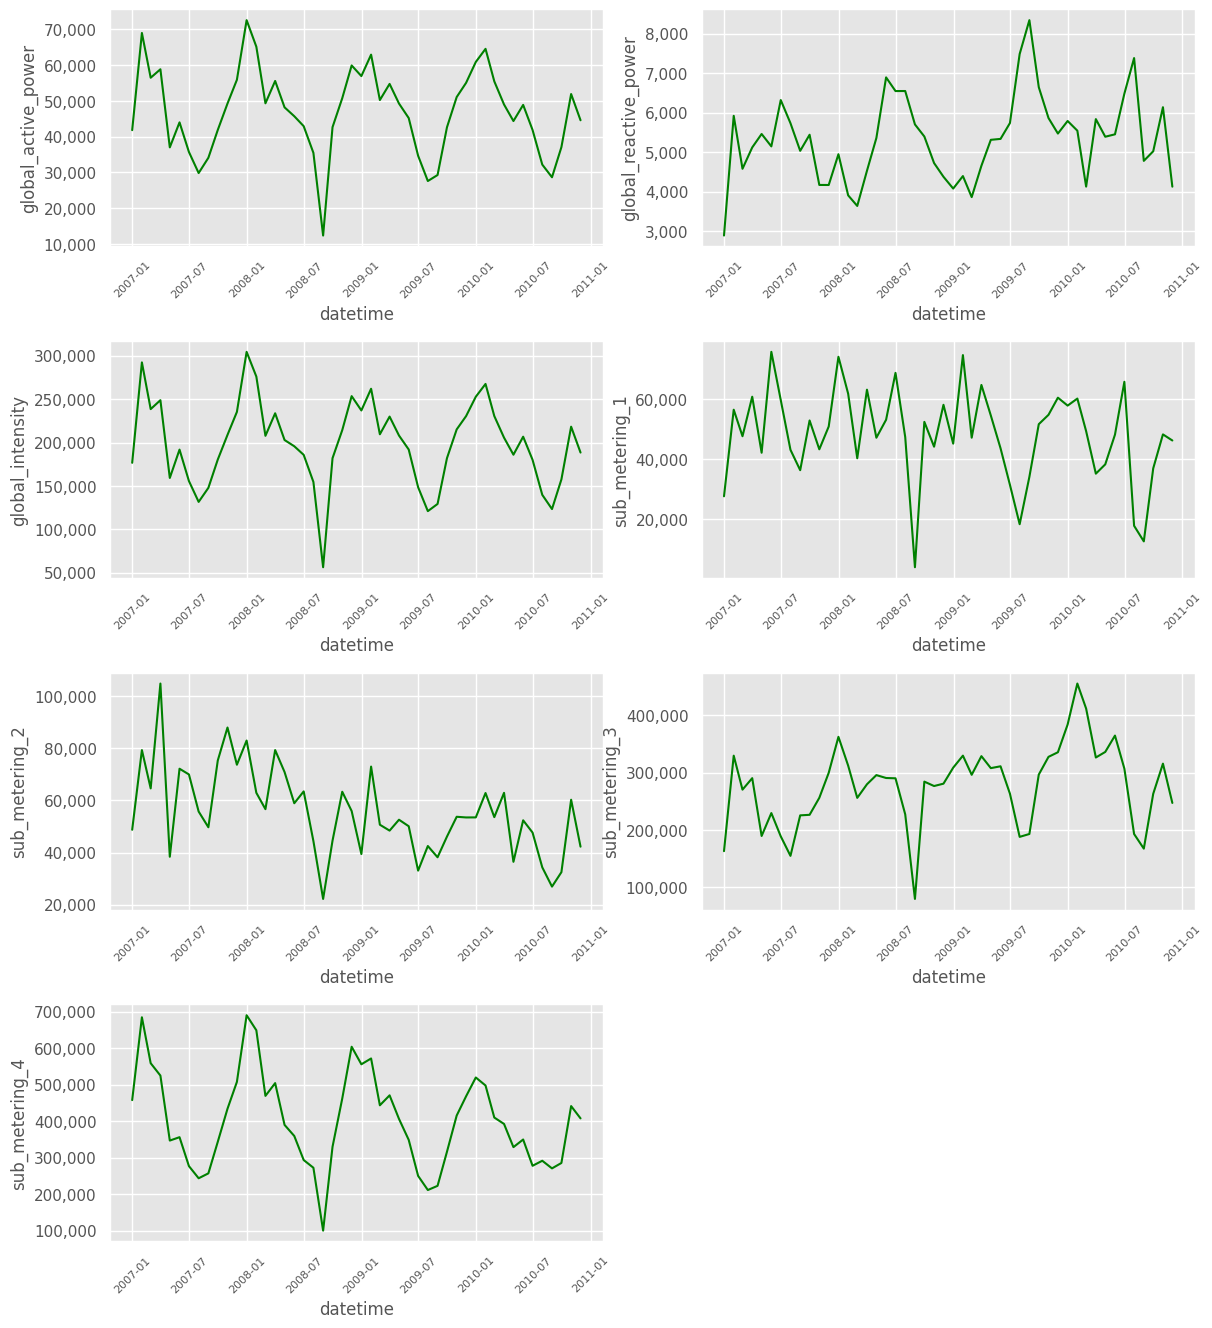

In [39]:
## Plotting features over time

# Features to plot
columns = mdf.columns

# Creating subplot axes
fig, axes = plt.subplots(4, 2, figsize=(14,16), sharey=False)
axes[3,1].set_axis_off()

# Iterating through axes and columns
for col, ax in zip(columns, axes.flatten()):
    sns.lineplot(data=mdf, x=mdf.index, y=col, ax=ax, color='green')
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.subplots_adjust(hspace=0.4);

---

# 6. Modelling

Types of LSTM Models:
* Univariate Single-Step Prediction
* Multivariate Single-Step Prediction
* Univariate Multi-Step Prediction
* Multivariate Multi-Step Prediction

What does this mean? Let's explore this a little bit further with an example for Univariate Single-Step Prediction LSTM Models:

There are problems comprised of a single series of observations and a model is required to learn from the series of past observations to predict the next value in the sequence. Before a univariate series can be modeled, it must be prepared. **The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.**

In [ ]:
# Consider a given univariate sequence as input (equal to a feature/column):
# [10, 20, 30, 40, 50, 60, 70, 80, 90]

The sequence can be divided into **multiple input/output patterns called samples** by making use of a **sliding window approach**, where three time steps are used as input (past observations) and one time step is used as output (future observations) for the **one-step prediction** that is being learned.

In [ ]:
# Input, Output: X, y
# [10, 20, 30] 40
# [20, 30, 40] 50
# [30, 40, 50] 60
# [40, 50, 60] 70
# [50, 60, 70] 80
# [60, 70, 80] 90

This sequence transformation will be performed in the respective data preparation steps prior to modeling.

**Note!** LSTM models expect a certain **shape of input for each sample** specified in the `input_shape=(n_steps, n_features)` argument in terms of the number of time steps and the number of features. The input X has the shape `[samples, timesteps]`. Since LSTM models will always expect multiple samples as the input component of training data, X needs to be re-shaped into the following dimensions or shape: `[samples, timesteps, features]`

## 6.1. Functions

### 6.1.1. Splitting data into train and test

In [ ]:
def split_data(data, test_size=0.2, analysis='univariate'):
    """
    Function to split time series data into train and test set
    Parameters:
        test_size: float, default=0.2
        analysis: {'univariate', 'univariate'}, default='univariate'
    """
    if analysis == 'univariate':
        position = int(round(len(data) * (1-test_size)))
        train = np.array(data[:position]).reshape(-1,1)
        test = np.array(data[position:]).reshape(-1,1)

    elif analysis == 'multivariate':
        position = int(round(len(data) * (1-test_size)))
        train = data[:position]
        test = data[position:]

    else:
        print("Please specify if analysis is univariate or multivariate")

    return train, test

### 6.1.2. Scaling data

In [ ]:
def scale(data, train_split):
    """
    Function to scale the entire dataset using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)

    return (data - data_mean) / data_std

In [ ]:
def inv_scale(data, scaled_data, train_split):
    """
    Function to inverse scaling of data by using the mean and standard deviation of the training data only
    """
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)

    return scaled_data * data_std + data_mean

### 6.1.3. Create samples

Out in the wild this process is sometimes called create features, to supervised (X, y) or data windowing (input and labels)

**LSTM model type: Univariate multi-step prediction**

In [ ]:
def create_samples_univar(data, n_input, n_output):
    """
    Function to convert time series observations
    into input X and output y
    """
    X, y = [], []

    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i])
        y.append(data[i : i+n_output])

    return np.array(X), np.array(y)

**LSTM model type: Multivariate multi-step prediction**

In [ ]:
def create_samples_multivar(data, n_input, n_output, target_index=0):
    """
    Function to convert time series observations
    into input X and output y
    """
    X, y = [], []

    # Move column defined by target_index to first position
    a = data[:, target_index].reshape(-1,1)
    b = np.delete(data, target_index, axis=1)
    data = np.concatenate((a, b), axis=1)

    for i in range(n_input, len(data)): #start, stop
        if i+n_output > len(data):
            break
        X.append(data[i-n_input : i, :])
        y.append(data[i : i+n_output, 0])

    return np.array(X), np.array(y)

### 6.1.4. Model evaluation

Evaluation is a process during development of the model to check whether the model is best fit for the given problem and corresponding data.

In [ ]:
def summarize_scores(name, score, scores):
    """
    Function to summarize scores
    """
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
def plot_model(history):
    """
    Function to plot training and validation loss
    """
    plt.figure(figsize=(10,5))
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16);

## 6.2. Part 1: Univariate LSTM Models (multi-step prediction)

* Number of features: 1
* Multi-step prediction

A time series forecasting problem that requires a **prediction of multiple time steps** into the future can be referred to as **multi-step time series forecasting.**
Specifically, these are problems where the forecast horizon or interval is **more than one time step.**
There are **two main types of LSTM models** that can be used **for multi-step forecasting**, which are:

**1. Vector Output Model**

**2. Encoder-Decoder Model**

#### Data Input

In [ ]:
# Input data: Global_active_power (total daily consumption)
feature = ddf['global_active_power']
feature.index = ddf.reset_index()['datetime']
feature.head()

#### Data Scaling

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

In [ ]:
# Define train/test split
test_size = 0.25
TRAIN_SPLIT = int(round(len(ddf) * (1-test_size)))
TRAIN_SPLIT

In [ ]:
# Get data values
univar_data = feature.values
univar_data

**Note!** The mean and standard deviation should *only* be computed using the training data

In [ ]:
# Scale data (using training data)
univar_data_scaled = scale(univar_data, TRAIN_SPLIT)
univar_data_scaled.shape, univar_data_scaled

#### Train and Test Split

In [ ]:
# Split data into train and test
train, test = split_data(data=univar_data_scaled, test_size=test_size, analysis='univariate')

# Print shape and first 5 values for train set
print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
print(train[:5])

In [ ]:
# Visualize train/test split
plt.figure(figsize=(12,4))
plt.plot(ddf.iloc[:len(train), 0])
plt.plot(ddf.iloc[len(train):, 0])
plt.xlabel('datetime')
plt.ylabel("global_active_power")
plt.tick_params(axis='x', labelrotation=45, labelsize=8)
plt.legend(['train','test']);

#### Create Samples

In [ ]:
# Create samples for train and test set
n_input = 14
n_output = 7

X_train, y_train = create_samples_univar(train, n_input=n_input, n_output=n_output)
X_test, y_test = create_samples_univar(test, n_input=n_input, n_output=n_output)

# Print shape and first 3 values for train set
print("Shape X_train y_train:", X_train.shape, y_train.shape,
      "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')
for i in range(2):
    print(X_train[i], y_train[i])

**Sanity check if create_samples did a good job**

In [ ]:
train[-5:], test[-5:]

In [ ]:
X_train[-1], y_train[-1]

In [ ]:
X_test[-1], y_test[-1]

In [ ]:
X_train[0], y_train[0]

In [ ]:
X_test[0], y_test[0]

### 6.2.1. LSTM Model With Univariate Input and Vector Output

Like other types of neural network models, the **LSTM can output a vector directly that can be interpreted as a multi-step forecast.**

Data already has the correct input shape `[samples, timesteps, features]`

#### Stacked LSTM Model

In [ ]:
# Create model
clear_session()

n_features = X_train.shape[2]
n_input = X_train.shape[1]
n_output = y_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse', metrics='mae') # mae: mean absolute error

model.summary()

In [ ]:
%%time

# Fit model
epochs = 50
verbose = 0
batch_size = 16 #default 32

history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(X_test, y_test))

Optionally, use EarlyStopping callback to interrupt training when the validation loss is not longer improving

In [ ]:
# %%time

# # Fit model
# callbacks = EarlyStopping(monitor="val_loss", patience=5)
# epochs = 100
# verbose = 0
# batch_size = 16 #default 32

# history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, callbacks=callbacks,
#                     batch_size=batch_size, validation_data=(X_test, y_test))

#### Optimization Learning Curves

In [ ]:
plot_model(history)

In [ ]:
# Loss and mae value for the model in test mode
score = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test mae: {score[1]:.4f}')

In [ ]:
# List all data in history
print(history.history.keys())

In [ ]:
history.history["loss"][:5]

In [ ]:
history.history["mae"][:5]

#### Model Prediction

In [ ]:
# Reshape data for prediction into [1, n_input, 1]
x_input = X_test[0].reshape((1, len(X_test[0]), 1))
x_input.shape

In [ ]:
# Make prediction
yhat = model.predict(x_input, verbose=0)

print(yhat.shape)
yhat

**Inverse Data Scaling**

In [ ]:
# Inverse scaling of prediction
yhat_inv = inv_scale(univar_data, yhat, TRAIN_SPLIT)
print(yhat_inv.shape)
yhat_inv

In [ ]:
# Inverse scaling of X_test, y_test
X_test_inv = inv_scale(univar_data, X_test, TRAIN_SPLIT)
y_test_inv = inv_scale(univar_data, y_test, TRAIN_SPLIT)

X_test_inv.shape, y_test_inv.shape

#### Plot Model Prediction

In [ ]:
# Plot prediction
plt.figure(figsize=(6,3.5))

past_seq = range(-len(X_test[0])+1, 1)
future_seq = np.arange(1, len(y_test[0])+1)

plt.plot(past_seq, X_test_inv[0], color='blue', marker='.', label='History')
plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

plt.xlabel('Time-Step')
plt.ylabel('Daily Power Consumption (kW)')
plt.xticks(range(-n_input,n_output,2))
plt.title('Univariate Stacked LSTM model: Multi-step prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

In [ ]:
## Now randomly select 3 more samples from the test set, perform model prediction and plot results

for i in random.sample(range(len(X_test)), 3):
    print(f"Randomly selected sample: {i}")

    # Reshape data for prediction into [1, n_input, 1]
    x_input = X_test[i].reshape((1, len(X_test[i]), 1))

    # Make prediction
    pred = model.predict(x_input, verbose=0)

    # Inverse scaling of prediction
    pred_inv = inv_scale(univar_data, pred, TRAIN_SPLIT)

    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[i], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
    plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Univariate Stacked LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

#### Evaluation Metric: RMSE

In [ ]:
# Actual values
actual = y_test_inv[0]

# Predicted values
predicted = yhat_inv.reshape(-1,1)

In [ ]:
actual.shape, predicted.shape

In [ ]:
actual

In [ ]:
predicted

In [ ]:
# Calculate RMSE score for each day
rmse_day = []

for i in range(actual.shape[0]):
    # calculate rmse
    rmse = mean_squared_error(actual[i], predicted[i], squared=False)
    rmse_day.append(rmse)

rmse_day

In [ ]:
# Store RMSE scores of each day in df
df_rmse = pd.DataFrame(rmse_day, columns=['Univariate Stacked LSTM'])

In [ ]:
# Plot RMSE score for each day
future_seq = np.arange(1, len(y_test[0])+1)

plt.figure(figsize=(6,3.5))
plt.plot(future_seq, rmse_day, marker='o', color='darkred')
plt.xlabel('Time-Step')
plt.ylabel('RMSE (kW)')
plt.title('Univariate Stacked LSTM model: RMSE per Day forecast');

In [ ]:
# Calculate overall RMSE score (for the respective forecast period)
rmse_total = mean_squared_error(actual, predicted, squared=False)
rmse_total

In [ ]:
# Store overall RMSE score in dict
performance_rmse = {}
performance_rmse['Univariate Stacked LSTM'] = rmse_total

In [ ]:
# Summarize scores
summarize_scores('RMSE scores for Univariate Stacked LSTM [total] per day', rmse_total, rmse_day)

### 6.2.2. Encoder-Decoder LSTM Model

**A model specifically developed for forecasting variable length output sequences is called the Encoder-Decoder LSTM.** The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another. This model can be used for multi-step time series forecasting.

As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

**The encoder is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used** such as Stacked, Bidirectional, and CNN models.

Data already has the correct input shape `[samples, timesteps, features]`

#### Encoder-Decoder LSTM Model

In [ ]:
# Create model
clear_session()

n_features = X_train.shape[2]
n_input = X_train.shape[1]
n_output = y_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_output))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse', metrics='mae')

model.summary()

In [ ]:
%%time

# Fit model
epochs = 50
verbose = 0
batch_size = 16 #default 32

history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(X_test, y_test))

Optionally, use EarlyStopping callback to interrupt training when the validation loss is not longer improving

In [ ]:
# %%time

# # Fit model
# callbacks = EarlyStopping(monitor="val_loss", patience=10)
# epochs = 100
# verbose = 0
# batch_size = 16 #default 32

# history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, callbacks=callbacks,
#                     batch_size=batch_size, validation_data=(X_test, y_test))

#### Optimization Learning Curves

In [ ]:
plot_model(history)

In [ ]:
# Loss and mae value for the model in test mode
score = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test mae: {score[1]:.4f}')

In [ ]:
# List all data in history
print(history.history.keys())

In [ ]:
history.history["loss"][:5]

In [ ]:
history.history["mae"][:5]

#### Model Prediction

In [ ]:
# Reshape data for prediction into [1, n_input, 1]
x_input = X_test[0].reshape((1, len(X_test[0]), 1))
x_input.shape

In [ ]:
# Make prediction
yhat = model.predict(x_input, verbose=0)

print(yhat.shape)
yhat

**Inverse Data Scaling**

In [ ]:
# Inverse scaling of prediction
yhat_inv = inv_scale(univar_data, yhat, TRAIN_SPLIT)
print(yhat_inv.shape)
yhat_inv

In [ ]:
# Inverse scaling of X_test, y_test
X_test_inv = inv_scale(univar_data, X_test, TRAIN_SPLIT)
y_test_inv = inv_scale(univar_data, y_test, TRAIN_SPLIT)

X_test_inv.shape, y_test_inv.shape

#### Plot Model Prediction

In [ ]:
# Plot prediction
plt.figure(figsize=(6,3.5))

past_seq = range(-len(X_test[0])+1, 1)
future_seq = np.arange(1, len(y_test[0])+1)

plt.plot(past_seq, X_test_inv[0], color='blue', marker='.', label='History')
plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

plt.xlabel('Time-Step')
plt.ylabel('Daily Power Consumption (kW)')
plt.xticks(range(-n_input,n_output,2))
plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

In [ ]:
## Now randomly select 3 more samples from the test set, perform model prediction and plot results

for i in random.sample(range(len(X_test)), 3):
    print(f"Randomly selected sample: {i}")

    # Reshape data for prediction into [1, n_input, 1]
    x_input = X_test[i].reshape((1, len(X_test[i]), 1))

    # Make prediction
    pred = model.predict(x_input, verbose=0)

    # Inverse scaling of prediction
    pred_inv = inv_scale(univar_data, pred, TRAIN_SPLIT)

    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[i], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
    plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Univariate Encoder-Decoder LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

#### Evaluation Metric: RMSE

In [ ]:
# Actual values
actual = y_test_inv[0]

# Predicted values
predicted = yhat_inv.reshape(-1,1)

In [ ]:
actual.shape, predicted.shape

In [ ]:
actual

In [ ]:
predicted

In [ ]:
# Calculate RMSE score for each day
rmse_day = []

for i in range(actual.shape[0]):
    # calculate rmse
    rmse = mean_squared_error(actual[i], predicted[i], squared=False)
    rmse_day.append(rmse)

rmse_day

In [ ]:
# Store RMSE scores of each day in df
df_rmse['Univariate Encoder-Decoder LSTM'] = rmse_day

In [ ]:
# Plot RMSE score for each day
future_seq = np.arange(1, len(y_test[0])+1)

plt.figure(figsize=(6,3.5))
plt.plot(future_seq, rmse_day, marker='o', color='darkred')
plt.xlabel('Time-Step')
plt.ylabel('RMSE (kW)')
plt.title('Univariate Encoder-Decoder LSTM model: RMSE per Day forecast');

In [ ]:
# Calculate overall RMSE score (for the respective forecast period)
rmse_total = mean_squared_error(actual, predicted, squared=False)
rmse_total

In [ ]:
# Store overall RMSE score in dict
performance_rmse.update( {'Univariate Encoder-Decoder LSTM' : rmse_total} )

In [ ]:
# Summarize scores
summarize_scores('RMSE scores for Univariate Stacked LSTM [total] per day', rmse_total, rmse_day)

## 6.3. Part 2: Multivariate LSTM Models (multi-step prediction)

* Number of features: >1
* Multi-step prediction

In this section, each of the time series variables is used to predict the next days of daily total power consumption. Each one-dimensional time series is provided to the model as a separate sequence of input. The LSTM will in turn create an internal representation of each input sequence that will together be interpreted by the decoder. Using multivariate inputs is helpful for those problems where the output sequence is some function of the observations at prior time steps from multiple different features, not just (or including) the feature being forecasted.

#### Data Input

As can be seen from the correlation heatmap, global intensity highly correlates with other features and will therefore be dropped. Voltage was already dropped before as it is a constant value

In [ ]:
# Select features
features = ddf.drop(['global_intensity'], axis=1)
features.head()

In [ ]:
features.tail(3)

#### Data Scaling

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

In [ ]:
# Define train/test split
test_size = 0.25
TRAIN_SPLIT = int(round(len(ddf) * (1-test_size)))
TRAIN_SPLIT

In [ ]:
# Get data values
multivar_data = features.values

**Note!** The mean and standard deviation should *only* be computed using the training data

In [ ]:
# Scale data (using training data)
multivar_data_scaled = scale(multivar_data, TRAIN_SPLIT)
multivar_data_scaled.shape, multivar_data_scaled[0]

#### Train and Test Split

In [ ]:
# Split data into train and test
train, test = split_data(data=multivar_data_scaled, test_size=test_size, analysis='multivariate')

# Print shape and first 5 values for train set
print("Shape train:", train.shape, "\nShape test:", test.shape, '\n')
print(train[:9])
print(test[:9])

#### Create Samples

In [ ]:
# Create samples for train and test set
n_input = 14
n_output = 7
target_index = 0

X_train, y_train = create_samples_multivar(train, n_input=n_input, n_output=n_output, target_index=target_index)
X_test, y_test = create_samples_multivar(test, n_input=n_input, n_output=n_output, target_index=target_index)

# Print shape and first 3 values for train set
print("Shape X_train y_train:", X_train.shape, y_train.shape,
      "\nShape X_test y_test:", X_test.shape, y_test.shape, '\n')
for i in range(3):
    print(X_train[i], y_train[i])

**Sanity check if create_samples did a good job**

In [ ]:
train[-5:], test[-5:]

In [ ]:
X_train[-1], y_train[-1]

In [ ]:
X_test[-1], y_test[-1]

In [ ]:
X_train[0], y_train[0]

In [ ]:
X_test[0], y_test[0]

### 6.3.1. LSTM Model With Multivariate Input and Vector Output

Like other types of neural network models, the **LSTM can output a vector directly that can be interpreted as a multi-step forecast.**

Data already has the correct input shape `[samples, timesteps, features]`

#### Stacked LSTM

In [ ]:
# Create model
clear_session()

n_features = X_train.shape[2]
n_input = X_train.shape[1]
n_output = y_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse', metrics='mae')

model.summary()

In [ ]:
%%time

# Fit model
epochs = 50
verbose = 0
batch_size = 16 #default 32

history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(X_test, y_test))

Optionally, use EarlyStopping callback to interrupt training when the validation loss is not longer improving

In [ ]:
# %%time

# # Fit model
# callbacks = EarlyStopping(monitor="val_loss", patience=10)
# epochs = 100
# verbose = 0
# batch_size = 16

# history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, callbacks=callbacks,
#                     batch_size=batch_size, validation_data=(X_test, y_test))

#### Optimization Learning Curves

In [ ]:
plot_model(history)

In [ ]:
# Loss and mae value for the model in test mode
score = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test mae: {score[1]:.4f}')

In [ ]:
# List all data in history
print(history.history.keys())

In [ ]:
history.history["loss"][:5]

In [ ]:
history.history["mae"][:5]

#### Model Prediction

In [ ]:
# Reshape data for prediction into [1, n_input, n_features]
x_input = X_test[0].reshape((1, len(X_test[0]), n_features))
x_input.shape

In [ ]:
# Make prediction
yhat = model.predict(x_input, verbose=0)

print(yhat.shape)
yhat

**Inverse Data Scaling**

In [ ]:
# Inverse scaling of prediction
yhat_inv = inv_scale(multivar_data[:,0], yhat, TRAIN_SPLIT)
print(yhat_inv.shape)
yhat_inv

In [ ]:
# Inverse scaling of X_test, y_test
X_test_inv = inv_scale(multivar_data, X_test, TRAIN_SPLIT)
y_test_inv = inv_scale(multivar_data[:,0], y_test, TRAIN_SPLIT)

X_test_inv.shape, y_test_inv.shape

#### Plot Model Prediction

In [ ]:
# Plot prediction
plt.figure(figsize=(6,3.5))

past_seq = range(-len(X_test[0])+1, 1)
future_seq = np.arange(1, len(y_test[0])+1)

plt.plot(past_seq, X_test_inv[0][:,0], color='blue', marker='.', label='History')
plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

plt.xlabel('Time-Step')
plt.ylabel('Daily Power Consumption (kW)')
plt.xticks(range(-n_input,n_output,2))
plt.title('Multivariate Stacked LSTM model: Multi-step prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

In [ ]:
## Now randomly select 3 more samples from the test set, perform model prediction and plot results

for i in random.sample(range(len(X_test)), 3):
    print(f"Randomly selected sample: {i}")

    # Reshape data for prediction into [1, n_input, n_features]
    x_input = X_test[i].reshape((1, len(X_test[i]), n_features))

    # Make prediction
    pred = model.predict(x_input, verbose=0)

    # Inverse scaling of prediction
    pred_inv = inv_scale(univar_data, pred, TRAIN_SPLIT)

    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[i][:,0], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
    plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Multivariate Stacked LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

#### Evaluation Metric: RMSE

In [ ]:
# Actual values
actual = y_test_inv[0].reshape(-1,1)

# Predicted values
predicted = yhat_inv.reshape(-1,1)

In [ ]:
actual.shape, predicted.shape

In [ ]:
actual

In [ ]:
predicted

In [ ]:
# Calculate RMSE score for each day
rmse_day = []

for i in range(actual.shape[0]):
    # calculate rmse
    rmse = mean_squared_error(actual[i], predicted[i], squared=False)
    rmse_day.append(rmse)

rmse_day

In [ ]:
# Store RMSE scores of each day in df
df_rmse['Multivariate Stacked LSTM'] = rmse_day

In [ ]:
# Plot RMSE score for each day
future_seq = np.arange(1, len(y_test[0])+1)

plt.figure(figsize=(6,3.5))
plt.plot(future_seq, rmse_day, marker='o', color='darkred')
plt.xlabel('Time-Step')
plt.ylabel('RMSE (kW)')
plt.title('Multivariate Stacked LSTM model: RMSE per Day forecast');

In [ ]:
# Calculate overall RMSE score (for the respective forecast period)
rmse_total = mean_squared_error(actual, predicted, squared=False)
rmse_total

In [ ]:
# Store overall RMSE score in dict
performance_rmse.update( {'Multivariate Stacked LSTM' : rmse_total} )

In [ ]:
# Summarize scores
summarize_scores('RMSE scores for Multivariate Stacked LSTM [total] per day', rmse_total, rmse_day)

### 6.3.2. Encoder-Decoder Model

**A model specifically developed for forecasting variable length output sequences is called the Encoder-Decoder LSTM.** The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another. This model can be used for multi-step time series forecasting.

As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

**The encoder is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used** such as Stacked, Bidirectional, and CNN models.

Data already has the correct input shape `[samples, timesteps, features]`

#### Encoder-Decoder LSTM Model

In [ ]:
# Create model
clear_session()

n_features = X_train.shape[2]
n_input = X_train.shape[1]
n_output = y_train.shape[1]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_output))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse', metrics='mae')

model.summary()

In [ ]:
%%time

# Fit model
epochs = 50
verbose = 0
batch_size = 16 #default 32

history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(X_test, y_test))

Optionally, use EarlyStopping callback to interrupt training when the validation loss is not longer improving

In [ ]:
# %%time

# # Fit model
# callbacks = EarlyStopping(monitor="val_loss", patience=5)
# epochs = 100
# verbose = 0
# batch_size = 16

# history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, callbacks=callbacks,
#                     batch_size=batch_size, validation_data=(X_test, y_test))

#### Optimization Learning Curves

In [ ]:
plot_model(history)

In [ ]:
# Loss and mae value for the model in test mode
score = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test mae: {score[1]:.4f}')

In [ ]:
# List all data in history
print(history.history.keys())

In [ ]:
history.history["loss"][:5]

In [ ]:
history.history["mae"][:5]

#### Model Prediction

In [ ]:
# Reshape data for prediction into [1, n_input, n_features]
x_input = X_test[0].reshape((1, len(X_test[0]), n_features))
x_input.shape

In [ ]:
# Make prediction
yhat = model.predict(x_input, verbose=0)

print(yhat.shape)
yhat

**Inverse Data Scaling**

In [ ]:
# Inverse scaling of prediction
yhat_inv = inv_scale(multivar_data[:,0], yhat, TRAIN_SPLIT)
print(yhat_inv.shape)
yhat_inv

In [ ]:
# Inverse scaling of X_test, y_test
X_test_inv = inv_scale(multivar_data, X_test, TRAIN_SPLIT)
y_test_inv = inv_scale(multivar_data[:,0], y_test, TRAIN_SPLIT)

X_test_inv.shape, y_test_inv.shape

#### Plot Model Prediction

In [ ]:
# Plot prediction
plt.figure(figsize=(6,3.5))

past_seq = range(-len(X_test[0])+1, 1)
future_seq = np.arange(1, len(y_test[0])+1)

plt.plot(past_seq, X_test_inv[0][:,0], color='blue', marker='.', label='History')
plt.plot(future_seq, y_test_inv[0], marker='x', label='True Future')
plt.plot(future_seq, yhat_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

plt.xlabel('Time-Step')
plt.ylabel('Daily Power Consumption (kW)')
plt.xticks(range(-n_input,n_output,2))
plt.title('Multivariate Encoder-Decoder LSTM model: Multi-step prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

In [ ]:
## Now randomly select 3 more samples from the test set, perform model prediction and plot results

for i in random.sample(range(len(X_test)), 3):
    print(f"Randomly selected sample: {i}")

    # Reshape data for prediction into [1, n_input, n_features]
    x_input = X_test[i].reshape((1, len(X_test[i]), n_features))

    # Make prediction
    pred = model.predict(x_input, verbose=0)

    # Inverse scaling of prediction
    pred_inv = inv_scale(multivar_data[:,0], pred, TRAIN_SPLIT)

    # Plot prediction
    plt.figure(figsize=(6,3.5))

    past_seq = range(-len(X_test[0])+1, 1)
    future_seq = np.arange(1, len(y_test[0])+1)

    plt.plot(past_seq, X_test_inv[i][:,0], color='blue', marker='.', label='History')
    plt.plot(future_seq, y_test_inv[i], marker='x', label='True Future')
    plt.plot(future_seq, pred_inv.reshape(-1,1), color='green', marker='o', label='Model Prediction')

    plt.xlabel('Time-Step')
    plt.ylabel('Daily Power Consumption (kW)')
    plt.xticks(range(-n_input,n_output,2))
    plt.title('Multivariate Encoder-Decoder LSTM model: Multi-step prediction')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);

#### Evaluation Metric: RMSE

In [ ]:
# Actual values
actual = y_test_inv[0].reshape(-1,1)

# Predicted values
predicted = yhat_inv.reshape(-1,1)

In [ ]:
actual.shape, predicted.shape

In [ ]:
actual

In [ ]:
predicted

In [ ]:
# Calculate RMSE score for each day
rmse_day = []

for i in range(actual.shape[0]):
    # calculate rmse
    rmse = mean_squared_error(actual[i], predicted[i], squared=False)
    rmse_day.append(rmse)

rmse_day

In [ ]:
# Store RMSE scores of each day in df
df_rmse['Multivariate Encoder-Decoder LSTM'] = rmse_day

In [ ]:
# Plot RMSE score for each day
future_seq = np.arange(1, len(y_test[0])+1)

plt.figure(figsize=(6,3.5))
plt.plot(future_seq, rmse_day, marker='o', color='darkred')
plt.xlabel('Time-Step')
plt.ylabel('RMSE (kW)')
plt.title('Multivariate Encoder-Decoder LSTM model: RMSE per Day forecast');

In [ ]:
# Calculate overall RMSE score (for the respective forecast period)
rmse_total = mean_squared_error(actual, predicted, squared=False)
rmse_total

In [ ]:
# Store overall RMSE score in dict
performance_rmse.update( {'Multivariate Encoder-Decoder LSTM' : rmse_total} )

In [ ]:
# Summarize scores
summarize_scores('RMSE scores for Multivariate Encoder-Decoder LSTM [total] per day', rmse_total, rmse_day)

## 6.4. Overall Model Performance Comparison

#### Lineplot - RMSE scores for each day across all models

In [ ]:
# Dataframe with RMSE scores for each day across all models
print(df_rmse.shape)
df_rmse.head()

In [ ]:
# Add 'Time_Step' column to df
df_rmse['Time_Step'] = np.arange(1, len(y_test[0])+1)

In [ ]:
# Convert df to long (tidy) form
dfm_rmse = df_rmse.melt('Time_Step', var_name='Models', value_name='RMSE (kW)')
dfm_rmse.head()

In [ ]:
# Plot RMSE scores for each day across all models
plt.figure(figsize=(6,3.5))

sns.lineplot(dfm_rmse, x='Time_Step', y='RMSE (kW)', hue='Models')
plt.title('LSTM Models: RMSE per Day forecast\n')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10);
plt.legend(loc='upper left', fontsize=10);

#### Barplot - Overall RMSE scores across all models

A model is considered skillful if it achieves performance better than a naive model, which is an **overall RMSE of about 465 kilowatts across a seven day forecast.**

In [ ]:
# Compile the overall RMSE scores
rmse_values = []

for name, value in performance_rmse.items():
    rmse_values.append(value)
    print(f'{name:12s}: {value:0.4f}')

In [ ]:
# Plot the overall RMSE scores (for the respective forecast period)
x = np.arange(len(performance_rmse))

plt.figure(figsize=(5,4))
plt.bar(x, rmse_values, width=0.5, color='blue')
plt.ylabel('RMSE (kW)')
plt.title(f'LSTM Models:\n\n Overall RMSE for a {n_output}-Day forecast period')
plt.xticks(ticks=x, labels=performance_rmse.keys(), rotation=45, ha='right');

**Documentation**
* Under the current conditions employed (e.g., number of input/output steps, model definitions), univariate models performed slightly better than multivariate models